# Bayesian Data Analysis - Project
___

__Note!__ The submitted notebooks need to illustrate the knowledge of the Bayesian workflow

__RUBRIC:__ 
* The introduction is inviting, presents an overview of the notebook. Information is relevant and presented in a logical order.
* The conclusion is clear
* The notebook presents a clear cohesive data analysis story, which is enjoyable to read
* Accuracy of use of statistical terms: Statistical terms are used accurately and with clarity 
* Description of the data, and the analysis problem
* Description of the model
* Description of the prior choices: Priors are listed and justiﬁed
* Is Stan code included?
* Is code for how Stan model is run included?
*  Is required convergence diagnostics (Rhat, divergences, neff) included?: Required onvergence diagnostic results shown and maning of the results is discussed
* Is there posterior predictive checking?
*  Is there a discussion of problems and potential improvements ?
___


In [4]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

import pystan
import stan_utility
import psis

#For hiding warnings that do not effect the functionality of the code
import warnings
warnings.filterwarnings('ignore')

## 1 Introduction


* The introduction is inviting, presents an overview of the notebook. Information is relevant and presented in a logical order. (Analysis problem)



## 2 Analysis problem
* Did you get a sense of what is the data and the analysis problem when they were ﬁrst introduced? Where and how might the author make the model description more clear?

## 3 Dataset
* image from the website
* spread (-11..11)
* win categories (1..6)
    * LL 1
    * ...
    * WW 6
* mapping table (1..46)
* print the final dataset

In [37]:
# Read data and preprocess it
data = []

filenames = os.listdir(r'./data/')
for idx, filename in enumerate(filenames):
    #df = pd.read_csv(f'data//{filename}')
    col = np.loadtxt(f'data//{filename}').tolist()[0:67]
    if (idx == (len(filenames) - 1)):
        last = col[0:67]
    else:
        data.append(col)

np_data = np.array(data)
#+ other stuff

# preview some first rows
#data.head()

# some summary
#data.describe()

#print number of observations (matches) and number of predictors (tournaments)

67
67
67
67
67
(5, 67)



## 4 Prior choices
* normal
* uniform

https://people.eecs.berkeley.edu/~jordan/courses/260-spring10/lectures/lecture5.pdf

 (Priors are listed and justiﬁed)
 We will go with 2 priors for the std: inverse gamma and uniform. The normal is based on the assumption that the expected observation is close to the middle. 
 
**(what is the default variance for inverse gamma if not given, how ab alpha, beta)
 
**(ask what is the default std for normal in stan if not provided)**

Uniform prior is based on the assumption that each observation is equally likely to happen.
 

## 5 Model

Combing with priors choice we have 4 different models:
* pooled with uniform prior for std
* pooled with inverse gamma prior for std
* hierarchical with uniform prior for std
* hierarchical with inverse gamma prior for std

-> show formula
-> explain why not separate! 
Since the goal is to predict the distribution of a new tournament, separate model is included because it can't used to make prediction. 

(binomial: uniform prior + logit binomial likelihood)

Did you get a sense of what is the model? Where and how might the author make the model description more clear?


## 6 Model comparison


__TO DO!__ In the separate model the mean ($theta$ in the Stan code) and the deviation ($sigma$ in the Stan code) is computed from the data for each machine separately.The Stan code below fits the given machine's data ($y$) to the normal distribution. Once the data has been fitted, the learned $theta$ and $sigma$ values can be used to compute the log-likelihood values of each observation ($N=30$) for every posterior draw ($S$). The resulting matrix ($SxN$) is later used in LOO-CV and P LOO-CV.

Explain stan code, fit model and do convergence diagnostic: rhat, divergences, neff 
* n_effs are high and Rhats<1.1, which is good
* Next we check divergences, E-BMFI and treedepth exceedences as explained in Robust Statistical Workflow with PyStan Case Study by Michael Betancourt.
*  Everything is fine based on these diagnostics and we can proceed with our analysis.


### 6.1 Pooled model

__TO DO!__ In the pooled model the mean ($theta$ in the Stan code) and the deviation ($sigma$ in the Stan code) is computed from the combined data of all machines. The combined data means that the data of the machines are common and no distinction between machines can be made. In this model, the same Stan code can be used (detailed description can be found from section 8.1).

In [76]:
print(np_data.T.shape)

(67, 5)


In [92]:
_#Show model
def print_model():
    with open('stan_code\\pool_uniform_prior.stan') as file:
        print(file.read())

pooled_data = np_data.flatten()
pooled_data_model = dict(N=len(pooled_data), y=pooled_data)

pooled_inv_g_data_model = dict(N=len(pooled_data), y=pooled_data)

hierarchical_data_model = dict(N = np_data.shape[1], J= np_data.shape[0],y = np_data.T)
# choosing alpha and beta?

def compute_model(file_path, data):
    # Compile model for both separated and pooled
    model = stan_utility.compile_model(file_path) 

    # Fit model
    fit = model.sampling(data=data, seed=194838)
    #stan_utility.check_treedepth(fit)
    #stan_utility.check_energy(fit)
    #stan_utility.check_div(fit)

    # print summary of selected variables
    # use pandas data frame for layout
    #summary = fit.summary(pars=['mu', 'sigma'])
    #df = pd.DataFrame(
    #    summary['summary'],
    #    index=summary['summary_rownames'],
    #    columns=summary['summary_colnames']
    #)
    
    return df, fit

def compare_yreds_against_actual_distribution(ypreds, actual):
    #..
    #..
    #...
    # FOR KRISTELLLLLLL
    pass

def compare_psis_loo(log_liks):
    ## compute psis_loo, p_eff
    ## plot k-values
    pass

def plot_ypred(fit):
    samples = fit.extract(permuted=True)
    ypred = samples['ypred']
    plt.hist(ypred, bins=100)
    

In [86]:
pool_uni_df, pool_uni_fit = compute_model(r'stan_code/pool_uniform_prior.stan', pooled_data_model)

Using cached StanModel


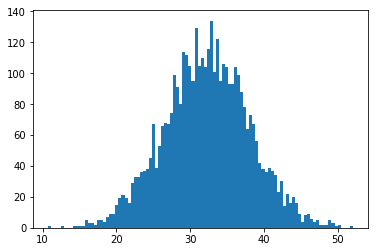

In [93]:
plot_ypred(pool_uni_fit)

In [102]:
pool_inv_df, pool_inv_fit = compute_model(r'stan_code/pool_inverse_gamma_prior.stan', pooled_data_model)



INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_810bada01bb5e9e25451b03bebe0beab NOW.


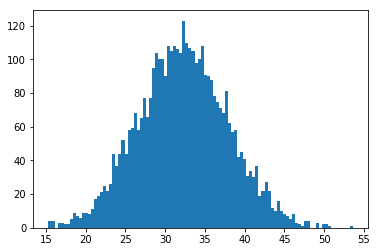

In [103]:
plot_ypred(pool_inv_fit)

In [ ]:
hier_uni_df, hier_uni_fit = compute_model(r'stan_code/hier_uniform_prior.stan', hierarchical_data_model)

Using cached StanModel


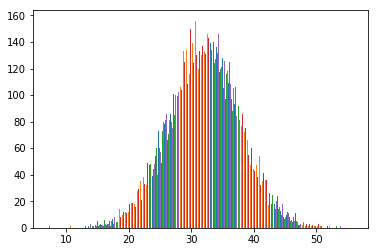

In [99]:
plot_ypred(hier_uni_fit)

In [100]:
hier_inv_df, hier_inv_fit = compute_model(r'stan_code/hier_inverse_gamma_prior.stan', hierarchical_data_model)

Using cached StanModel


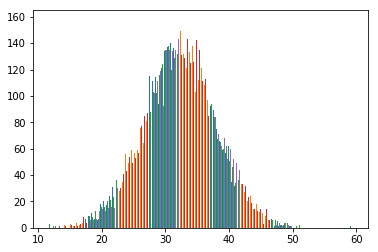

In [101]:
plot_ypred(hier_inv_fit)

### 6.2 Pooled model
__TO DO!__ In the pooled model the mean ($theta$ in the Stan code) and the deviation ($sigma$ in the Stan code) is computed from the combined data of all machines. The combined data means that the data of the machines are common and no distinction between machines can be made. In this model, the same Stan code can be used (detailed description can be found from section 8.1).



In [ ]:
# Fit model
y_pooled = []
for i in range(0,len(factoryData.columns)):
    y_pooled.extend(factoryData[i].values)
model_data = dict(N = len(y_pooled), y = y_pooled)
pfit = model.sampling(data=model_data, seed=194838)
stan_utility.check_treedepth(pfit)
stan_utility.check_energy(pfit)
stan_utility.check_div(pfit)
print(pfit)

### 6.3 Hierarchical model
__TO DO!__ The hierarchical model is a combination of the separated and pooled models. This means that in this exercise, each machine has own mean $\theta_j$ ($theta[J]$ in Stan code) and common standard deviation $\sigma^2$ ($sigma$ in Stan code). Furthermore, all the means are controlled by common hyperparameters $\mu_p$ ($theta0$) and $\sigma^2_p$ ($sigma0$) which means that the means are drawn from the common distribution described by these hyperparameters.The Stan code below fits the data of each machine ($y[:,j]$) to normal distribution using the machine specific mean drawn from common distribution ($theat[j]$) and common standard deviation ($sigma$). Once the common mean distribution has been computed and the data has been fitted, the learned $theta[j]$ and $sigma$ values can be used to compute the log-likelihood values of each observation ($N=30$) for every posterior draw ($S$). The resulting matrix ($SxN$) is later used in LOO-CV and P LOO-CV.

In [106]:
# Show model
with open('stan_code\\hierarchical_model.stan') as file:
    print(file.read())
    
# Compile model      
hmodel = stan_utility.compile_model('hierarchical_model.stan')

# Fit model
model_data = dict(N = len(factoryData), 
                  J= len(factoryData.columns),
                  y = factoryData.as_matrix())
hfit = hmodel.sampling(data=model_data, seed=194838, chains=6,iter=4000)
stan_utility.check_treedepth(hfit)
stan_utility.check_energy(hfit)
stan_utility.check_div(hfit)
print(hfit)

// Gaussian hierarchical model with common std
data {
  int<lower=0> N; 			// Number of observations
  int<lower=0> J; 			// Number of machines
  matrix[N,J] y; 			// N measurements for J machines
}
parameters {
  real theta0;				// Common theta for each J machine's theta
  real<lower=0> sigma0;			// Common std for each J machines theta
  real theta[J];			// Machine specific theta
  real<lower=0> sigma;			// Common std
}
model {
  for (j in 1:J)
    theta[j] ~ normal(theta0, sigma0);	// Model for computing machine specific theta from common theta0 and sigma0
  for (j in 1:J)
    y[:,j] ~ normal(theta[j], sigma);	// Model for fitting data using machine specific theta and common std
}
generated quantities {
  matrix[N,J] log_lik;    
  real ypred[J];
  real theta_new;
  real ypred_new;
  
  for (j in 1:J)
     ypred[j] = normal_rng(theta[j], sigma);	// Predictive distibutions of all the machines
  theta_new = normal_rng(theta0, sigma0);	// Next posterior distribution from commonly learne

### 6.4 PSIS-LOO and $P_{LOO-CV}$ 

__TO DO!__ The PSIS-LOO values of the models can be computed using provided _psisloo_ function. The function returns observation specific _k_-values and PSIS-LOO-CV values. In addition it return the sum of the PSIS-LOO-CV values, hence the sum of the LOO log desnities:

\begin{equation*}
lppd_{loo-cv} = \sum_{i=1}^{N} log \left( \frac{1}{S} \sum_{s=1}^{S} p(y_i|\theta^{is}) \right)
\end{equation*}

The estimated effective number of parameters ($P_{LOO-CV}$) in the model is computed as follows:

\begin{equation*}
p_{loo-cv} = lppd-lppd_{loo-cv} 
\end{equation*}

where $lppd$ is the sum of the log densities of the posterior draws:
\begin{equation*}
lppd = \sum_{i=1}^{N} log \left( \frac{1}{S} \sum_{s=1}^{S} p(y_i|\theta^{s}) \right)
\end{equation*}


All the PSIS-LOO values, estimated effective number of parameters and plotted _k_-values are shown below.


In [ ]:
# LPPD: Posterior predictive distribution summarized by the simulation draws of theta^s
def compute_LPPD(samples):
    lppd_all = 0
    samples = np.array(samples)
    N = samples.shape[1]
    S = samples.shape[0]
    for i in range(0,N):
        lppd_all += np.log(np.sum(np.exp(samples[:,i]))/S)
    return lppd_all

# LPPD LOO-CV: Bayesian loo-cv (leave-one-out cross-validation) estimate of out-of-sample predictive fit
def compute_PSIS_LOO_values_and_plot_k(samples, model_text='Separate model'):
    # Compute bayesian loo-cv using psisloo function
    lppd_loo_cv, lppd_loos_cv, lppd_loo_k = psis.psisloo(samples)

    #Estimate of the effective number of parameters
    p_loo_cv = compute_LPPD(samples) - lppd_loo_cv
    
    # Plot k-values
    plt.scatter(range(0,samples.shape[1]),lppd_loo_k,label=model_text, alpha=0.7)
    
    return {'loo_cv':lppd_loo_cv, 'loos_cv':lppd_loos_cv, 'loo_k':lppd_loo_k, 'p_loo_cv': p_loo_cv}

#Reshape matrix of [SxNxJ] to [Sx(N*J)]
def reshape_array(samples):
    samples_all = np.array(samples)
    S = samples_all.shape[0]
    N = samples_all.shape[1]
    J = samples_all.shape[2]
    samples_reshaped = []
    for s in range(0,S):
        temp = []
        for n in range(0,N):
            for j in range(0,J):
                temp.append(samples_all[s,n,j])
        samples_reshaped.append(temp)
    return np.array(samples_reshaped)


#samples = sfit.extract(permuted=True)
#compute_PSIS_LOO_values_and_plot_k(reshape_array(samples["log_lik"]))

# check the number of large (> 0.5) Pareto k estimates
#np.sum(ks1 > 0.5)


## 7 Predictive performance assessment 
* Model selection according to the hightest LOO-CV sum
* Reliability based on the _k_values: <0.7 ok, <0.5 good


## 8 Posterior predictive checking 
* show predictive distributions: all tournaments and new tournament
* how to check?? demo6_x

run compare_yreds_against_actual_distribution

In [ ]:
#Show predictive distributions for all the machines and for new machine
def show_predictive_distributions(samples):
    m = 0;
   
    #First row of plots: machines from 1 to 4
    fig, axes = plt.subplots(1, 4, sharey=True,figsize=(16,4), subplot_kw=dict(aspect='auto'))
    fig.suptitle('Predictive distributions of the machines')
    for i in range(0,4):
        axes[i].set_title('Machine '+str(m+1))
        mu = np.mean(samples["ypred"][:,m])
        if mu<85:
            axes[i].hist(samples["ypred"][:,m],50, density=True, alpha=0.3, color='R')
        else:
            axes[i].hist(samples["ypred"][:,m],50, density=True, alpha=0.7)
        axes[i].plot([85,85],[0.027, 0],'-',color='K',linewidth=1.5, label=r'$\theta=85$')
        axes[i].plot([mu,mu],[0.027, 0],'--',color='K', linewidth=1.5, label=r'$\theta$ mean')
        m+=1
        axes[i].legend()
    plt.show()   
    
    #Second row of plots: machines from 5 to 6 and new machine (7th)
    fig, axes = plt.subplots(1, 3, sharey=True,figsize=(12,4), subplot_kw=dict(aspect='auto'))
    for i in range(0,2):
        axes[i].set_title('Machine '+str(m+1))
        mu = np.mean(samples["ypred"][:,m])
        if mu<85:
            axes[i].hist(samples["ypred"][:,m],50, density=True, alpha=0.3, color='R')
        else:
            axes[i].hist(samples["ypred"][:,m],50, density=True, alpha=0.7)
        axes[i].plot([85,85],[0.027, 0],'-',color='K',linewidth=1.5, label=r'$\theta=85$')
        axes[i].plot([mu,mu],[0.027, 0],'--',color='K', linewidth=1.5, label=r'$\theta$ mean')
        m+=1
        axes[i].legend()

    i=2
    axes[i].set_title('Machine '+str(m+1))
    mu = np.mean(samples["ypred7"])
    if mu<85:
        axes[i].hist(samples["ypred7"],50, density=True, alpha=0.3, color='R')
    else:
        axes[i].hist(samples["ypred7"],50, density=True, alpha=0.7)
    axes[i].plot([85,85],[0.027, 0],'-',color='K',linewidth=1.5, label=r'$\theta=85$')
    axes[i].plot([mu,mu],[0.027, 0],'--',color='K', linewidth=1.5, label=r'$\theta$ mean')
    axes[i].legend()
    plt.show()   


## 9 Sensitivity analysis (?)
* on the priors 
* and the model (ask ta)


## 10 Conclusion
* problems: 
 - data model is not 100& justifiable 
* potential improvements
 - data model can be modified so that multinomial can be used for likelihood
 - extensive experiment with binomial model
* discussion
 - it's accurate
* conclusion of the data analysis
* Is there a discussion of problems and potential improvements ?

___

# EXTRA TEST

In [3]:
raw_data = np.loadtxt('data.txt')

# Aggregate raw result
aggregated_result = {}
for i in range(-11,12):
    aggregated_result[str(i)] = []

for (spread, result) in raw_data:
    key = str(int(spread))
    aggregated_result[key].append(result)
        
# Turn to 23 x 3 matrix, where columns are win, lose, number of games, and rows are the possible spread
data_matrix = []
for key, value in aggregated_result.items():
    total = len(value)
    win = len([i for i in value if i > 0])
    data_matrix.append([win, total - win, total])

print(data_matrix)
print(len(data_matrix))
print(aggregated_result)

[[0, 0, 0], [3, 10, 13], [2, 6, 8], [1, 8, 9], [2, 5, 7], [3, 7, 10], [3, 8, 11], [5, 6, 11], [5, 1, 6], [2, 1, 3], [3, 3, 6], [30, 0, 30], [0, 0, 0], [5, 3, 8], [5, 0, 5], [10, 4, 14], [10, 5, 15], [15, 1, 16], [5, 3, 8], [4, 0, 4], [5, 1, 6], [0, 0, 0], [17, 4, 21]]
23
{'-11': [], '-10': [0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], '-9': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0], '-8': [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], '-7': [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0], '-6': [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0], '-5': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0], '-4': [0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0], '-3': [1.0, 0.0, 1.0, 1.0, 1.0, 1.0], '-2': [0.0, 1.0, 1.0], '-1': [1.0, 1.0, 0.0, 0.0, 0.0, 1.0], '0': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], '1': [], '2': [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0], '3

In [97]:
# Read data and convert it to matrix with dimensions [6x23]
raw_data = pd.read_csv('data.txt', sep=" ", header=None)
raw_data.columns = ['spread','win']
raw_data = raw_data.groupby(['spread', 'win']).size().reset_index(name='counts')


data_json = {i: [0 for j in range(-11,12)] for i in range(1,7)}
for index, row in raw_data.iterrows():
    data_json[row['win']][11+row['spread']] = row['counts']

data = pd.DataFrame(data=data_json)
def getRowText():
    j=-11
    c = {}
    for i in range(0,23):
        c[i] = j
        j += 1
    return c

data.rename(index=getRowText(), inplace=True)
data = data.T
print(data)

   -11  -10  -9   -8   -7   -6   -5   -4   -3   -2  ...    2    3    4    5   \
1    0    7    4    6    3    5    6    4    0    1 ...     1    0    3    3   
2    0    2    1    0    1    1    2    0    0    0 ...     1    0    0    1   
3    0    1    1    2    1    1    0    2    1    0 ...     1    0    1    1   
4    0    0    0    1    1    1    1    2    2    0 ...     2    2    3    2   
5    0    1    1    0    0    1    0    0    1    1 ...     1    0    1    0   
6    0    2    1    0    1    1    2    3    2    1 ...     2    3    6    8   

    6    7    8    9    10   11  
1    1    2    0    0    0    2  
2    0    0    0    0    0    1  
3    0    1    0    1    0    1  
4    1    1    0    1    0    6  
5    1    1    0    0    0    2  
6   13    3    4    4    0    9  

[6 rows x 23 columns]


In [103]:
def convertData(dataset):
    win = dataset[0:3].sum(axis=0).values 
    lose = dataset[3:7].sum(axis=0).values 
    return np.array([win,lose])

tt = convertData(data)


array([ 0, 10,  6,  8,  5,  7,  8,  6,  1,  1,  3,  0,  0,  3,  0,  4,  5,
        1,  3,  0,  1,  0,  4], dtype=int64)

In [ ]:
# Data #######
raw_data = pd.read_csv('kristel.txt', sep=" ", header=None)
print(raw_data)


highest_frequency = max([8,8,7,7,6,6,5,5,4,3,2])+2
#data = dict(N=11, n=[highest_frequency for i in range(0,11)], 
#            y=np.array(list(reversed([8,8,7,7,6,6,5,5,4,3,2]))), x=[1,2,3,4,5,6,7,8,9,10,11])
data = dict(r=23, c=3, y=data_matrix)

def fit_model(model_code='stan_code\\binom-logistic-regression.stan'):
    model = stan_utility.compile_model(model_code)
    fit = model.sampling(data=data, seed=194838, chains=4, iter=4000)
    samples = fit.extract(permuted=True)
    print(fit)
    stan_utility.check_treedepth(fit)
    stan_utility.check_energy(fit)
    stan_utility.check_div(fit)
    return samples

In [4]:
# Models
with open('stan_code\\binom-logistic-regression.stan') as file:
    print(file.read())

// Binomial model with linear fit prior
data {
  int<lower=0> N;
  int n[N];  //Number of trials per spread
  row_vector[N] x; //Spreads
  int y[N];  //Number of successes per spread
}
parameters {
  real alpha; 
  real beta; 
}
transformed parameters {
  row_vector[N] p;
  p=inv_logit(alpha + beta*x);
}
model {
  y ~ binomial(n,p); //Note! Probabilities should be constrained to lie between 0 and 1.
}
generated quantities {
 vector[N] y_rep;
 for(i in 1:N){
  y_rep[i] <- binomial_rng(n[i],p[i]); //posterior draws to get posterior predictive checks
 }
}


In [6]:
# logistic_samples = fit_model('stan_code\\binom-logistic-regression.stan')

In [34]:
logistic_samples = fit_model('stan_code\\multinomial.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_64050bdb4345f8556d8cea2a5498a672 NOW.
C:\Users\phuct\Miniconda3\envs\stan\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\phuct\AppData\Local\Temp\tmp73xard5o\stanfit4anon_model_64050bdb4345f8556d8cea2a5498a672_4005347848322932037.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Inference for Stan model: anon_model_64050bdb4345f8556d8cea2a5498a672.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]   0.34  3.0e-3   0.24   0.01   0.13    0.3   0.51   0.85   6501    1.0
theta[2]   0.33  2.8e-3   0.23   0.01   0.13   0.29   0.49   0.83   6903    1.0
theta[3]   0.33  3.1e-3   0.24   0.01   0.13   0.29    0.5   0.85   5906    1.0
lp__       -4.5    0.02   1.15  -7.65  -4.99  -4.15  -3.66  -3.33   3026    1.0

Samples were drawn using NUTS at Thu Nov 29 14:00:15 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
0 of 8000 iterations saturated the maximum tree depth of 10 (0.0%)
0.0 of 8000 iterations ended with a divergence (0.0%)


In [9]:
####### Multinomial #######






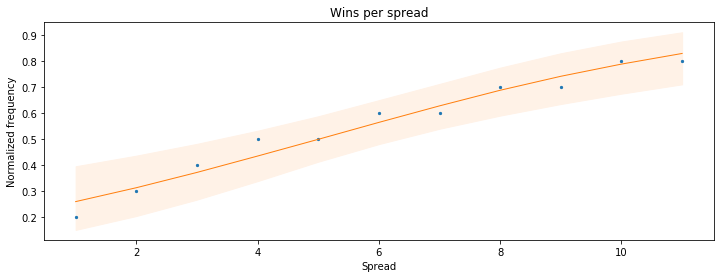

In [16]:
def show_model_fit(x, y, mu):    
    figsize = plt.rcParams['figure.figsize'].copy()
    figsize[0] *= 2  # width
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # scatterplot and lines
    color_scatter = 'C0'  # 'C0' for default color #0
    color_line = 'C1'     # 'C1' for default color #1
    # lighten color_line
    color_shade = (1 - 0.1*(1 - np.array(mpl.colors.to_rgb(color_line))))
    # plot
    ax.fill_between(
        x,
        np.percentile(mu, 5, axis=0),
        np.percentile(mu, 95, axis=0),
        color=color_shade
    )
    ax.plot(
        x,
        np.percentile(mu, 50, axis=0),
        color=color_line,
        linewidth=1
    )
    ax.scatter(x, y, 5, color=color_scatter)
    ax.set_xlabel('Spread')
    ax.set_ylabel('Normalized frequency')
    ax.set_title('Wins per spread')
    plt.show()
    
show_model_fit(data["x"],data["y"]/np.array([highest_frequency]), logistic_samples['p'])

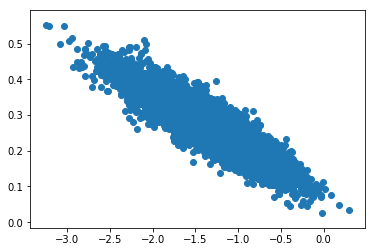

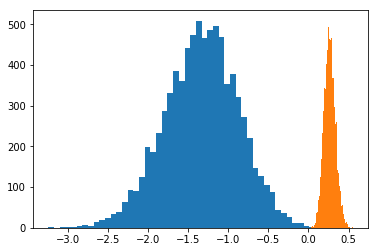

'plt.scatter(data["x"],data["y"]/np.array([highest_frequency]))\ndef calc(a,b,xp):\n    return np.exp(a + b*xp)/(1 + np.exp(a + b*xp))'

In [17]:
"""from scipy import stats
for i in range(0,11):
    mu = np.mean(logistic_samples['y_rep'][:,i])
    std = np.std(logistic_samples['y_rep'][:,i])
    x = np.linspace(0,11,100)
    plt.plot(x, stats.norm(mu,std).pdf(x))
    #plt.hist(logistic_samples['y_rep'][:,i], alpha=0.2, density=True)
plt.show()
"""


plt.scatter(logistic_samples["alpha"],logistic_samples["beta"])
plt.show();
plt.hist(logistic_samples["alpha"], bins=50)
plt.hist(logistic_samples["beta"], bins=50)
plt.show();

"""plt.scatter(data["x"],data["y"]/np.array([highest_frequency]))
def calc(a,b,xp):
    return np.exp(a + b*xp)/(1 + np.exp(a + b*xp))"""